# **Data Harmonization**

Nowadays, people still tend to confuse *Data Science* with *Big Data*. Indeed, we have more data than ever before. However, there are still large industries where *Small Data* is extremely common. A clear example of this is the **Clinical Research**, where the rarity of a disease, the cost, and the disponibility of subjects make it extremely harder to get a decent dataset.

For this reason, **multi-site neuroimaging studies** are becoming more and more frequent among medical studies. Multi-site neuroimaging studies mean that the data which compose the dataset comes from different sources. An example of this is a dataset that is built from two different samples, which were collected in different places.

This allowed to conduct studies without having to worry about the problems of small datasets (Over-Fitting, Outliers, noise...). But all this come with a slight disadvantage, having data from different sources usually implies to handle with non-biological variance introduced by the application of different techniques or the use of different machines. 

Fortunately, some research has been done through this topic. The procediments involved in solving this type of issues are called **Harmonization Techniques**.

## *1. Load the Data*

In [1]:
from load_data import data_loader

full_dataset, fa, func, gm = data_loader(unzip=False)

In [2]:
full_dataset

,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-caudalmiddlefrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-cuneus,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-entorhinal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-fusiform,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiorparietal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiortemporal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-isthmuscingulate,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lateraloccipital,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lateralorbitofrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lingual,...,gm-ctx-rh-superiortemporal/ctx-rh-transversetemporal,gm-ctx-rh-superiortemporal/ctx-rh-insula,gm-ctx-rh-supramarginal/ctx-rh-transversetemporal,gm-ctx-rh-supramarginal/ctx-rh-insula,gm-ctx-rh-transversetemporal/ctx-rh-insula,age,sex,dd,edss,controls_ms
002MSVIS,0.395567,0.000000,0.0,0.0,0.382439,0.392177,0.490902,0.000000,0.356278,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,51.53,1,22.18,7.5,1
003MSVIS,0.330618,0.000000,0.0,0.0,0.357768,0.346572,0.457750,0.329869,0.354733,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,58.06,0,9.57,6.0,1
004MSVIS,0.418653,0.000000,0.0,0.0,0.408343,0.000000,0.492659,0.419281,0.387314,0.0,...,0.00000,0.00000,0.00000,0.00000,0.00000,60.78,1,6.79,3.0,1
005MSVIS,0.378885,0.000000,0.0,0.0,0.394806,0.420584,0.478323,0.368988,0.306003,0.0,...,0.00000,0.54170,0.00000,0.00000,0.00000,37.95,0,8.45,1.5,1
010MSVIS,0.354844,0.000000,0.0,0.0,0.390623,0.404013,0.452600,0.000000,0.366199,0.0,...,0.00000,0.54818,0.00000,0.00000,0.00000,52.64,0,9.05,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,0.437912,0.000000,0.0,0.0,0.436493,0.000000,0.513600,0.000000,0.429750,0.0,...,0.00000,0.56132,0.00000,0.55679,0.00000,32.98,1,-1.00,0.0,0
sFIS_05,0.453001,0.000000,0.0,0.0,0.485008,0.000000,0.510843,0.000000,0.442475,0.0,...,0.00000,0.55271,0.00000,0.54804,0.00000,23.76,0,-1.00,0.0,0
sFIS_06,0.444399,0.000000,0.0,0.0,0.000000,0.000000,0.538231,0.000000,0.475603,0.0,...,0.00000,0.55568,0.00000,0.56064,0.00000,24.11,0,-1.00,0.0,0
sFIS_07,0.486600,0.513572,0.0,0.0,0.490968,0.000000,0.539344,0.000000,0.000000,0.0,...,0.55051,0.57783,0.54053,0.56414,0.55666,23.98,0,-1.00,0.0,0


## *2. Basic information about the dataset*

For this project, our database is composed of **165** subjects, eighteen controls, and one hundred and forty-eight patients. The data is split into four different files: 3 files which include FA information, FUNC (functional) information, and GM_networks (Grey Matter) information (*Neuroimaging information*), and an xlsx file containing information such as the age and gender of the subjects as well as other useful data about the disease (*Clinical information*).

The subjects of this study comes from two different sources: *MSVIS* and *FIS*. In the following sections we'll determine if there is a problem related with "Scanner Effects" (multi-site neuroimaging problems) and, if necessary, we'll apply harmonization techniques.

## *3. Scanner Effects Detection*

One of the main studies in detection and harmonizing neuroimaging data belongs to Fortin et al. (2017), *Harmonization of cortical thickness measurements across scanners and sites*. In this project we'll apply the same detection techniques and solutions.

For *Scanner Effects* detection, they used dimensionality reduction techniques, such as *Principal Component Analysis* (PCA)to reduce the feature space to two dimensions. This allows to an easier visualization of the data.

### 3.1. PCA

*Principal Component Analysis* is, by far, the most used algorithm in terms of dimensionality reduction. Its popularity is due to its capacity to identify the hyperplane which stays closer to the data and then project the data in it.

One of the main characteristics of this algorithm is that preserves the variance. The first principal component takes the hyperplane which contains the maximum amount of variance, the second principal component takes the hyperplane which contains the second maximum amount of variance, and so on.

First of all, before applying PCA to our data, let's visualize the amount of variance taken by each principal component.

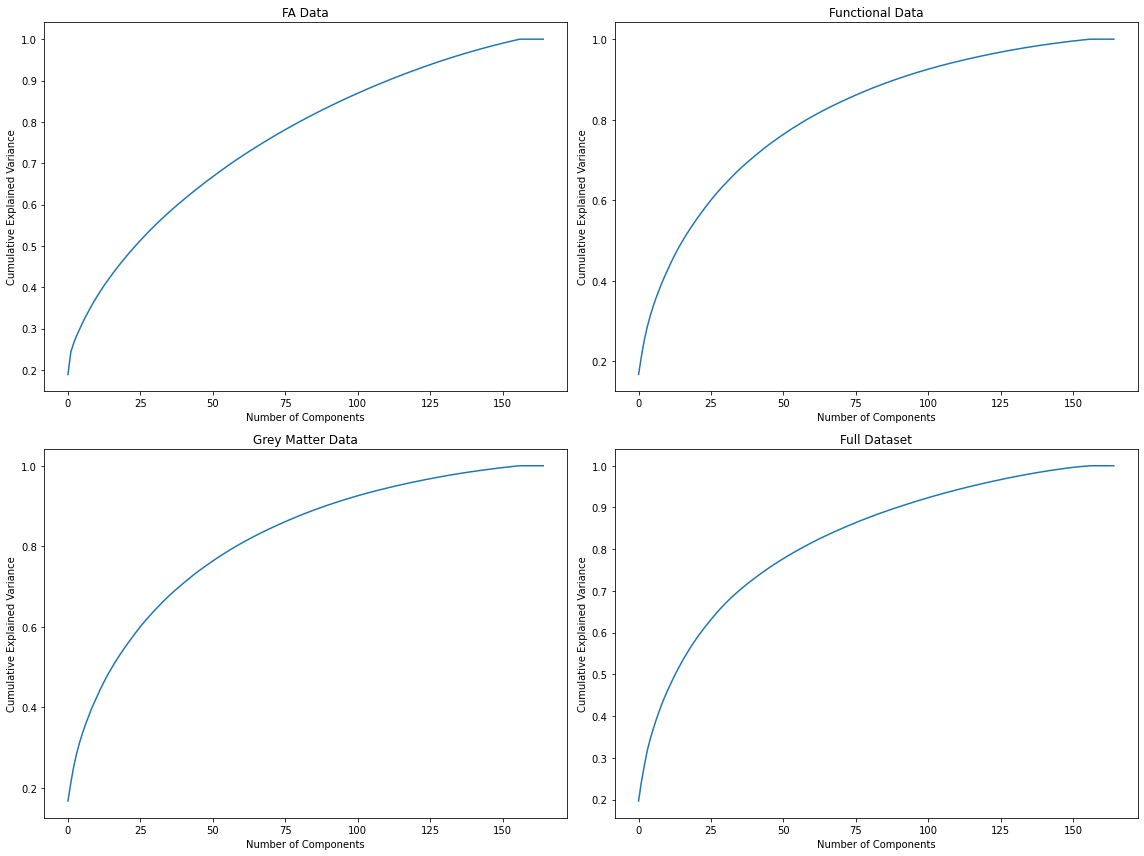

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

data = [fa.iloc[:, :-5], func.iloc[:, :-5], gm.iloc[:, :-5], full_dataset.iloc[:, :-5]]
names = ["FA Data", "Functional Data", "Grey Matter Data", "Full Dataset"]

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for i in range(2):
    for j in range(2):
        pca_variables = data[i+j]
        pca = PCA().fit(pca_variables)
        axs[i, j].plot(np.cumsum(pca.explained_variance_ratio_))

for i,ax in enumerate(axs.flat):
    ax.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance', title=names[i])

fig.tight_layout()

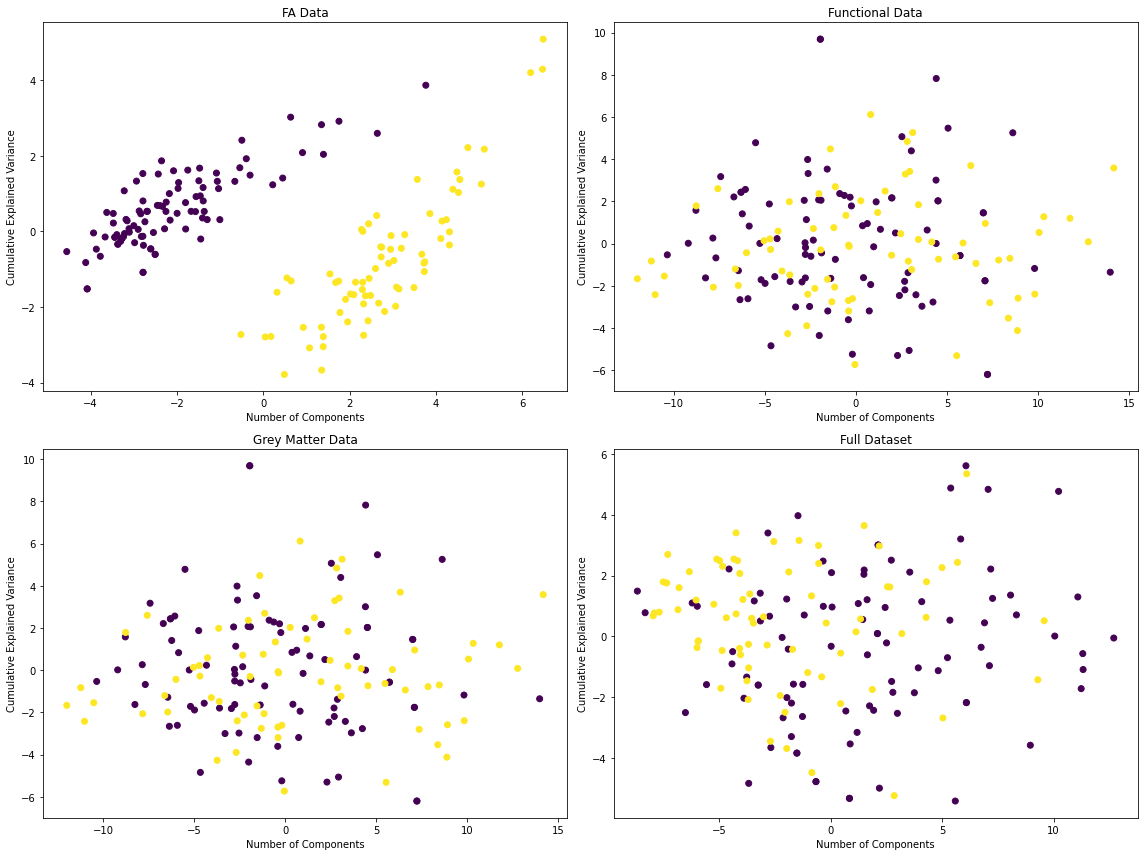

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
scanner = [0 if "MSVIS" in name else 1 for name in fa.index]

for i in range(2):
    for j in range(2):
        pca_variables = data[i+j]
        pca = PCA(n_components=2)
        pca_fa = pd.concat([pd.DataFrame(pca.fit_transform(pca_variables)), pd.DataFrame(scanner, columns=["scanner"])], join="inner", axis=1)
        axs[i, j].scatter(x=pca_fa[0], y=pca_fa[1], c=pca_fa["scanner"])

for i,ax in enumerate(axs.flat):
    ax.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance', title=names[i])
    
fig.tight_layout()

## 4. Data Harmonization: Combat

In [5]:
# DATA
data = fa.iloc[:, :-5].transpose()

# COVARS
index = [name for name in fa.index]
sample = [num for num in range(165)]
scanner = [0 if "MSVIS" in name else 1 for name in index]
age = [a for a in fa.iloc[:, -5]]
sex = [s for s in fa.iloc[:, -4]]
controls = [c for c in fa.iloc[:, -1]]

covars = pd.DataFrame(zip(index, sample, scanner, age, sex, controls), columns=["index", "sample", "scanner", "age", "sex", "controls_ms"])

# BATCH_COL
batch_col = "scanner"

# Continuous_cols

continuous_cols = ["age", "sex"]

# Categorical_cols

categorical_cols = ["controls_ms"] 

In [6]:
from neuroCombat import neuroCombat

nc = neuroCombat.neuroCombat(dat = data,
                        covars = covars,
                        batch_col = batch_col,
                        continuous_cols= continuous_cols,
                        categorical_cols = categorical_cols)

harmonized_fa = pd.DataFrame(np.transpose(nc["data"]), index = fa.iloc[:, :-5].index, columns= fa.iloc[:, :-5].columns)

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
c:\Users\franc\OneDrive\Documentos\Programació\Data Science\Projects\Capstone_Project\Francesc\neuroCombat\neuroCombat\neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


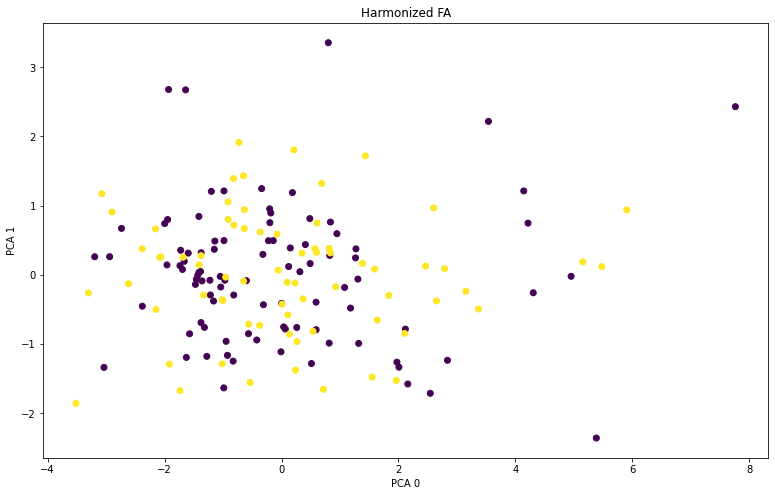

In [7]:
pca_variables = harmonized_fa
pca = PCA(n_components=2)
pca_fa = pd.concat([pd.DataFrame(pca.fit_transform(pca_variables)), covars["scanner"]], join="inner", axis=1)
plt.figure(figsize=(13, 8))
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.title("Harmonized FA")
plt.scatter(x=pca_fa[0], y=pca_fa[1], c=pca_fa["scanner"])

In [8]:
harmonized_fa = pd.concat([harmonized_fa, fa.iloc[:, -5:]], join = "inner", axis=1)
harmonized_fa

,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-caudalmiddlefrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-cuneus,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-entorhinal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-fusiform,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiorparietal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-inferiortemporal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-isthmuscingulate,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lateraloccipital,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lateralorbitofrontal,fa-ctx-lh-caudalanteriorcingulate/ctx-lh-lingual,...,fa-ctx-rh-superiortemporal/ctx-rh-transversetemporal,fa-ctx-rh-superiortemporal/ctx-rh-insula,fa-ctx-rh-supramarginal/ctx-rh-transversetemporal,fa-ctx-rh-supramarginal/ctx-rh-insula,fa-ctx-rh-transversetemporal/ctx-rh-insula,age,sex,dd,edss,controls_ms
002MSVIS,0.399312,-0.014400,-0.001972,-0.004052,0.318070,0.286953,0.502073,-0.012909,0.343535,-0.003907,...,0.348553,0.385115,0.365679,0.348416,0.353916,51.53,1,22.18,7.5,1
003MSVIS,0.332708,-0.014968,-0.001972,-0.007232,0.262841,0.251186,0.465328,0.262778,0.335609,-0.003449,...,0.317327,0.364023,0.335191,0.331354,0.349136,58.06,0,9.57,6.0,1
004MSVIS,0.423138,-0.014184,-0.001972,-0.005096,0.354410,-0.049281,0.504013,0.340227,0.380334,-0.002701,...,0.309762,0.361130,0.366381,0.363087,0.359324,60.78,1,6.79,3.0,1
005MSVIS,0.381954,-0.015439,-0.001972,-0.004963,0.358233,0.314005,0.488021,0.291492,0.279965,-0.006071,...,0.352858,0.406871,0.434700,0.420149,0.392932,37.95,0,8.45,1.5,1
010MSVIS,0.357493,-0.015095,-0.001972,-0.006620,0.331278,0.300292,0.459646,-0.014677,0.352578,-0.004155,...,0.286556,0.339371,0.359474,0.356579,0.353297,52.64,0,9.05,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sFIS_04,0.432691,0.032704,0.001877,0.033775,0.447914,0.131892,0.500440,0.063851,0.428656,0.008492,...,0.321571,0.362751,0.325036,0.384373,0.330074,32.98,1,-1.00,0.0,0
sFIS_05,0.447493,0.034484,0.001877,0.045221,0.478748,0.124340,0.498148,0.076260,0.438804,0.010987,...,0.351590,0.396622,0.418060,0.409795,0.380528,23.76,0,-1.00,0.0,0
sFIS_06,0.439178,0.034468,0.001877,0.045544,0.133053,0.124308,0.522669,0.076033,0.465475,0.010916,...,0.391048,0.407101,0.437568,0.422693,0.396020,24.11,0,-1.00,0.0,0
sFIS_07,0.479942,0.631027,0.001877,0.045424,0.483093,0.124320,0.523666,0.076117,0.083797,0.010942,...,0.367986,0.404728,0.372635,0.403007,0.355001,23.98,0,-1.00,0.0,0


In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(harmonized_fa.iloc[:, :-1], harmonized_fa.iloc[:, -1])
model.predict(harmonized_fa.iloc[0:1, :-1])

array([1], dtype=int64)

In [15]:
fa.iloc[:, -5:]

,age,sex,dd,edss,controls_ms
002MSVIS,51.53,1,22.18,7.5,1
003MSVIS,58.06,0,9.57,6.0,1
004MSVIS,60.78,1,6.79,3.0,1
005MSVIS,37.95,0,8.45,1.5,1
010MSVIS,52.64,0,9.05,2.0,1
...,...,...,...,...,...
sFIS_04,32.98,1,-1.00,0.0,0
sFIS_05,23.76,0,-1.00,0.0,0
sFIS_06,24.11,0,-1.00,0.0,0
sFIS_07,23.98,0,-1.00,0.0,0


In [32]:
def harmonization(neuro_data, clinical_data, batch_col):
    """
    Takes raw data and harmonizes it by using the Combat method.

    Arguments:
    ---------

    neuro_data: pandas dataframe or numpy array with the information related to neuroimaging or ROIs. The shape of the matrix has to be (Samples, Features)

    clinical_data: It contains data that we want to take into account in the harmonization process, rather if it's because we don't want to affect it 
    influence (like age or sex) or because we want to modify it's influence, scanner effects.

    batch_col: is the name of the column in "clinical_data" that we want to modify it's influence in the data.

    Returns:
    --------

    Pandas dataframe with the harmonized neuroimaging data concatenated with the clinical data provided
    
    """
    dat = neuro_data.transpose()
    
    index = [name for name in fa.index]
    scanner = [0 if "MSVIS" in name else 1 for name in index]

    clinical_data["scanner"] = scanner

    har_data = neuroCombat.neuroCombat(dat = dat,
                                       covars = clinical_data,
                                       batch_col = "scanner")

    clinical_data.drop(["scanner"], axis=1, inplace=True)

    return pd.concat([pd.DataFrame(har_data["data"].transpose(), index = neuro_data.index, columns = neuro_data.columns), clinical_data], 
                     join = "inner", 
                     axis=1)


h = harmonization(fa.iloc[:, :-5], fa.iloc[:, -5:], "scanner")

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
c:\Users\franc\OneDrive\Documentos\Programació\Data Science\Projects\Capstone_Project\Francesc\neuroCombat\neuroCombat\neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
